# Práctica 5: Análisis de Imagen (Fractografía SEM)


Incluye:
- Descubrimiento de imágenes en `files/p5` (o `files/P5`) del repositorio.
- Selección de imagen principal (p. ej. `fatigue.jpg`, `fatrigue2.png`) y división en 4 especímenes (2x2).
- Calibración de escala con clics sobre la barra de escala y entrada de longitud real (μm).
- Análisis cualitativo y cuantitativo: histogramas, ecualización, CLAHE, filtros, bordes (Sobel/Canny), umbralización (Otsu/adaptativa), morfología y etiquetado.
- Medición manual de características (μm) a partir de la calibración.
- Widgets interactivos para explorar parámetros y guardar resultados.
- Guardado de todas las figuras en `Practicas/P05_Analisis_Imagen/data/images` y resumen JSON.


In [1]:
# 1) Configuración del entorno y dependencias
import sys, os, re, json, math, logging, datetime as dt
from pathlib import Path
from typing import Iterable, Iterator, Tuple, Optional, List, Dict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Backends interactivos (opcional): ipympl mejora la interacción y ginput en notebooks
try:
    import ipywidgets as widgets
except Exception:
    widgets = None
    print('ipywidgets no disponible. Puedes instalarlo y recargar el cuaderno.')

# Intentar usar backend interactivo si ipympl existe
try:
    import ipympl  # noqa: F401
    matplotlib.use('module://ipympl.backend_nbagg')
except Exception:
    pass

# Filtros y utilidades de imagen
try:
    import cv2
except Exception:
    cv2 = None
    print('OpenCV (cv2) no disponible. Algunas funciones usarán scikit-image si está.')

try:
    from skimage import io as skio, color, filters, exposure, feature, morphology, measure, util
    from skimage.transform import rescale, resize
    from skimage.data import camera, coins, cells3d, chelsea
except Exception:
    skio = None

# Estilo
sns.set(context='notebook', style='whitegrid', palette='deep')
plt.rcParams['figure.dpi'] = 110
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger('P05')

# Estructura relativa: este notebook vive en Practicas/P05_Analisis_Imagen/notebooks
project_root = Path.cwd().parent  # .../Practicas/P05_Analisis_Imagen/
images_dir = project_root / 'data' / 'images'
data_dir = project_root / 'data'

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

ensure_dir(images_dir); ensure_dir(data_dir)

print('Si falta alguna dependencia, en una celda de Jupyter puedes ejecutar:')
print('%pip install numpy pandas matplotlib seaborn ipywidgets ipympl opencv-python scikit-image tqdm')

Si falta alguna dependencia, en una celda de Jupyter puedes ejecutar:
%pip install numpy pandas matplotlib seaborn ipywidgets ipympl opencv-python scikit-image tqdm


## Datos y utilidades

In [3]:
# 2) Utilidades para descubrir y leer imágenes en files/p5 (tolerantes a nombres)
IMG_EXTS = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}


def find_repo_root_from_notebook() -> Path:
    # notebooks -> P05_Analisis_Imagen -> Practicas -> repo_root (3 niveles arriba)
    repo_root = Path.cwd().parent.parent.parent
    if not (repo_root / 'files').exists():
        logger.warning(f"La raíz del repo detectada ({repo_root}) podría no ser 'Aero-Messure'.")
    return repo_root


def find_p5_data_root() -> Path:
    repo_root = find_repo_root_from_notebook()
    data_root_p5_upper = repo_root / 'files' / 'P5'
    data_root_p5_lower = repo_root / 'files' / 'p5'

    if data_root_p5_upper.is_dir():
        return data_root_p5_upper
    if data_root_p5_lower.is_dir():
        return data_root_p5_lower

    raise FileNotFoundError(f"No se encontró el directorio de datos 'files/p5' o 'files/P5' en {repo_root}")


def iter_image_files(p5_root: Path) -> Iterator[Path]:
    for f in p5_root.rglob('*'):
        if f.suffix.lower() in IMG_EXTS and f.is_file():
            yield f


def load_image(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """
    Retorna (rgb_uint8, gray_float01).
    Usa cv2 si está; en su defecto scikit-image.
    """
    if cv2 is not None:
        img_bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise RuntimeError(f'No se pudo leer: {path}')
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        gray01 = gray.astype(np.float32) / 255.0
        return img_rgb, gray01
    elif skio is not None:
        img = skio.imread(str(path))
        if img.ndim == 2:
            gray01 = util.img_as_float32(img)
            img_rgb = np.stack([img, img, img], axis=-1)
        else:
            if img.shape[-1] == 4:
                img = img[..., :3]
            img_rgb = img
            gray01 = color.rgb2gray(img_rgb).astype(np.float32)
        # Asegurar rango 0..1
        gray01 = np.clip(gray01, 0, 1).astype(np.float32)
        if img_rgb.dtype != np.uint8:
            img_rgb = (np.clip(img_rgb.astype(np.float32), 0, 1) * 255).astype(np.uint8)
        return img_rgb, gray01
    else:
        raise ImportError('No hay backend de imagen disponible (instala opencv-python o scikit-image).')


def split_quadrants(img_rgb: np.ndarray) -> List[np.ndarray]:
    """Divide una imagen en 4 cuadrantes (arriba-izq, arriba-der, abajo-izq, abajo-der)."""
    h, w = img_rgb.shape[:2]
    h2, w2 = h // 2, w // 2
    return [img_rgb[0:h2, 0:w2], img_rgb[0:h2, w2:w], img_rgb[h2:h, 0:w2], img_rgb[h2:h, w2:w]]


def show_rgb(img_rgb: np.ndarray, title: Optional[str] = None):
    plt.figure(figsize=(6, 5))
    plt.imshow(img_rgb)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.tight_layout()


def save_fig(path: Path):
    ensure_dir(path.parent)
    plt.savefig(path, dpi=150, bbox_inches='tight')
    logger.info(f'Guardado: {path}')


In [4]:
# 3) Descubrimiento de archivos en files/p5
try:
    p5_root = find_p5_data_root()
    logger.info(f'Raíz P5: {p5_root}')
except FileNotFoundError as e:
    logger.error(str(e))
    p5_root = None
    
records = []
if p5_root is not None:
    for f in iter_image_files(p5_root):
        records.append({'file': str(f), 'name': f.name, 'ext': f.suffix.lower(), 'dir': str(f.parent)})

DF_IMAGES = pd.DataFrame(records).sort_values(['name']).reset_index(drop=True)
display(DF_IMAGES.head())
logger.info(f'Imágenes detectadas: {len(DF_IMAGES)}')

if DF_IMAGES.empty and skio is None and cv2 is None:
    logger.error('No hay imágenes locales ni librerías de imagen disponibles.')


[INFO] Raíz P5: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P5


,file,name,ext,dir
0,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,fatigue.jpg,.jpg,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...
1,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,fatrigue2.png,.png,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...


[INFO] Imágenes detectadas: 2


In [ ]:
# 4) Calibración de escala con clics y mediciones
from dataclasses import dataclass

@dataclass
class Calibration:
    microm_per_pixel: float = None
    specimen_label: str = ''  # p.ej., "fatigue.jpg [idx=0]"


def pick_two_points(fig_ax=None, title='Seleccione 2 puntos sobre la barra de escala') -> Optional[List[Tuple[float, float]]]:
    """Devuelve dos puntos (x,y) tras clics del usuario. Requiere backend interactivo.
    Si no es posible, retorna None.
    """
    try:
        if fig_ax is None:
            fig, ax = plt.subplots(figsize=(6, 5))
        else:
            fig, ax = fig_ax
        if title:
            ax.set_title(title)
        plt.tight_layout()
        print('Haga dos clics sobre los extremos de la barra de escala...')
        pts = plt.ginput(2, timeout=-1)
        if len(pts) < 2:
            print('No se seleccionaron dos puntos.')
            return None
        return pts
    except Exception as ex:
        print(f'No se pudo capturar clics (pruebe instalar ipympl): {ex}')
        return None


def calibrate_from_bar(img_rgb: np.ndarray, length_um: Optional[float] = None) -> Optional[float]:
    """Permite seleccionar dos puntos en la barra de escala y calcular μm/píxel.
    length_um: longitud real de la barra (μm). Si es None, solicita por input().
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title('Seleccione 2 extremos de la barra de escala')
    pts = pick_two_points((fig, ax))
    if not pts:
        plt.close(fig)
        return None

    (x1, y1), (x2, y2) = pts
    dist_px = float(np.hypot(x2 - x1, y2 - y1))
    print(f'Distancia de barra en píxeles: {dist_px:.2f} px')
    plt.close(fig)

    if length_um is None:
        try:
            length_um = float(input('Ingrese la longitud real de la barra (μm), p.ej. 10: ').strip())
        except Exception:
            print('Entrada inválida; calibración cancelada.')
            return None

    if length_um <= 0:
        print('Longitud real debe ser positiva.')
        return None

    um_per_px = length_um / dist_px
    print(f'Calibración: {um_per_px:.4f} μm/px')
    return um_per_px


def measure_two_points(img_rgb: np.ndarray, um_per_px: float) -> Optional[float]:
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title('Seleccione 2 puntos a medir')
    pts = pick_two_points((fig, ax), title=None)
    if not pts:
        plt.close(fig)
        return None
    (x1, y1), (x2, y2) = pts
    dist_px = float(np.hypot(x2 - x1, y2 - y1))
    dist_um = dist_px * float(um_per_px)
    print(f'Distancia: {dist_um:.2f} μm ( {dist_px:.2f} px )')
    plt.close(fig)
    return dist_um

In [ ]:
# 5) Funciones de análisis: histogramas, contraste, filtros, bordes, umbrales, morfología

def analyze_specimen(img_rgb: np.ndarray, label: str, save_prefix: Optional[str] = None, auto_save: bool = True) -> Dict[str, Path]:
    out_paths: Dict[str, Path] = {}
    gray = (cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)/255.0).astype(np.float32) if cv2 is not None else (color.rgb2gray(img_rgb).astype(np.float32) if 'color' in globals() and hasattr(color,'rgb2gray') else (img_rgb[...,0].astype(np.float32)/255.0))

    # Histograma y CDF
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(img_rgb); ax[0].set_title(f'Especimen {label}'); ax[0].axis('off')
    ax[1].hist((gray*255).ravel(), bins=256, color='C0', alpha=0.7)
    ax[1].set_title('Histograma (grises)'); ax[1].set_xlabel('Nivel'); ax[1].set_ylabel('Frecuencia')
    fig.tight_layout()
    if auto_save and save_prefix:
        p = images_dir / f'{save_prefix}_hist.png'; save_fig(p); out_paths['hist'] = p
    plt.show()

    # Ecualización y CLAHE
    if cv2 is not None:
        gray8 = (np.clip(gray,0,1)*255).astype(np.uint8)
        he = cv2.equalizeHist(gray8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        he_clahe = clahe.apply(gray8)
    elif 'exposure' in globals() and hasattr(exposure,'equalize_hist'):
        he = (np.clip(exposure.equalize_hist(gray),0,1)*255).astype(np.uint8)
        he_clahe = (np.clip(exposure.equalize_adapthist(gray),0,1)*255).astype(np.uint8)
    else:
        he = he_clahe = (gray*255).astype(np.uint8)

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(img_rgb); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(he, cmap='gray'); ax[1].set_title('Ecualización'); ax[1].axis('off')
    ax[2].imshow(he_clahe, cmap='gray'); ax[2].set_title('CLAHE'); ax[2].axis('off')
    fig.tight_layout()
    if auto_save and save_prefix:
        p = images_dir / f'{save_prefix}_equalization.png'; save_fig(p); out_paths['equalization'] = p
    plt.show()

    # Filtros: Gauss, Mediana, Bilateral
    if cv2 is not None:
        g = cv2.GaussianBlur(gray8, (5,5), 1.0)
        m = cv2.medianBlur(gray8, 5)
        b = cv2.bilateralFilter(gray8, 9, 50, 50)
    else:
        g = (filters.gaussian(gray, 1.0) * 255).astype(np.uint8)
        m = (filters.median((gray*255).astype(np.uint8)) ).astype(np.uint8)
        b = g

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(g, cmap='gray'); ax[0].set_title('Gauss σ=1'); ax[0].axis('off')
    ax[1].imshow(m, cmap='gray'); ax[1].set_title('Mediana 5x5'); ax[1].axis('off')
    ax[2].imshow(b, cmap='gray'); ax[2].set_title('Bilateral'); ax[2].axis('off')
    fig.tight_layout()
    if auto_save and save_prefix:
        p = images_dir / f'{save_prefix}_filters.png'; save_fig(p); out_paths['filters'] = p
    plt.show()

    # Bordes: Sobel y Canny
    if cv2 is not None:
        sobelx = cv2.Sobel(gray8, cv2.CV_32F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray8, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.hypot(sobelx, sobely)
        mag = (np.clip(mag/np.max(mag+1e-6),0,1)*255).astype(np.uint8)
        can = cv2.Canny(gray8, 50, 150)
    else:
        sobel = filters.sobel(gray)
        mag = (np.clip(sobel,0,1)*255).astype(np.uint8)
        can = feature.canny(gray, sigma=1.0)

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(img_rgb); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(mag, cmap='gray'); ax[1].set_title('Gradiente (Sobel)'); ax[1].axis('off')
    ax[2].imshow(can, cmap='gray'); ax[2].set_title('Canny'); ax[2].axis('off')
    fig.tight_layout()
    if auto_save and save_prefix:
        p = images_dir / f'{save_prefix}_edges.png'; save_fig(p); out_paths['edges'] = p
    plt.show()

    # Umbrales: Otsu / Adaptativo
    if cv2 is not None:
        _, th_otsu = cv2.threshold(gray8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        th_adap = cv2.adaptiveThreshold(gray8, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 5)
    else:
        t = filters.threshold_otsu(gray)
        th_otsu = (gray > t)
        th_adap = th_otsu

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(img_rgb); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(th_otsu, cmap='gray'); ax[1].set_title('Otsu'); ax[1].axis('off')
    ax[2].imshow(th_adap, cmap='gray'); ax[2].set_title('Adaptativo'); ax[2].axis('off')
    fig.tight_layout()
    if auto_save and save_prefix:
        p = images_dir / f'{save_prefix}_thresholds.png'; save_fig(p); out_paths['thresholds'] = p
    plt.show()

    # Morfología y etiquetado básico
    if cv2 is not None:
        bin_img = th_otsu if isinstance(th_otsu, np.ndarray) else (th_otsu.astype(np.uint8)*255)
        kernel = np.ones((3,3), np.uint8)
        opened = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)
        closed = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=1)
        lbl_count = None
    else:
        bin_img = th_otsu
        opened = morphology.opening(bin_img, morphology.disk(1))
        closed = morphology.closing(bin_img, morphology.disk(1))
        lbl = measure.label(closed)
        lbl_count = int(lbl.max())

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(bin_img, cmap='gray'); ax[0].set_title('Binaria (Otsu)'); ax[0].axis('off')
    ax[1].imshow(opened, cmap='gray'); ax[1].set_title('Apertura'); ax[1].axis('off')
    ax[2].imshow(closed, cmap='gray');
    ttl = 'Cierre' + (f' (objetos: {lbl_count})' if lbl_count is not None else '')
    ax[2].set_title(ttl); ax[2].axis('off')
    fig.tight_layout()
    if auto_save and save_prefix:
        p = images_dir / f'{save_prefix}_morph.png'; save_fig(p); out_paths['morph'] = p
    plt.show()

    return out_paths

In [ ]:
# 6) Widgets interactivos: seleccionar imagen, espécimen, calibrar y analizar
if widgets is None:
    print('Widgets no disponibles. Instala ipywidgets e ipympl para máxima interactividad.')
else:
    # Opciones de imágenes disponibles o de respaldo (skimage.data)
    img_options = []
    for _, r in DF_IMAGES.iterrows():
        img_options.append(r['file'])
    fallback = []
    if not img_options:
        if skio is not None:
            # Guardar imágenes de ejemplo en memoria temporal
            from tempfile import gettempdir
            tmp = Path(gettempdir())
            f1 = tmp / 'sk_camera.png'; skio.imsave(f1, camera())
            f2 = tmp / 'sk_coins.png';  skio.imsave(f2, coins())
            img_options = [str(f1), str(f2)]
            fallback = ['sk_camera', 'sk_coins']
        else:
            print('Sin imágenes locales y sin skimage. Agrega archivos a files/p5.')

    dd_images = widgets.Dropdown(options=img_options, description='Imagen: ', layout={'width':'500px'})
    spec_idx = widgets.ToggleButtons(options=[0,1,2,3], value=0, description='Espécimen:')
    scale_len = widgets.FloatText(value=10.0, description='Barra (μm):', step=0.5)
    btn_calib = widgets.Button(description='Calibrar (clic 2 pts)', button_style='warning')
    lbl_calib = widgets.Label(value='μm/px: (sin calibrar)')
    auto_save = widgets.Checkbox(value=True, description='Guardar figuras')
    out = widgets.Output()

    calib = Calibration()

    def load_main_and_specimen(path: str, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        img_rgb, _ = load_image(Path(path))
        quads = split_quadrants(img_rgb)
        idx = max(0, min(3, int(idx)))
        return img_rgb, quads[idx]

    def on_calibrate_clicked(_):
        with out:
            out.clear_output(wait=True)
            try:
                _, spec = load_main_and_specimen(dd_images.value, spec_idx.value)
                um_per_px = calibrate_from_bar(spec, scale_len.value)
                if um_per_px:
                    calib.microm_per_pixel = um_per_px
                    calib.specimen_label = f"{Path(dd_images.value).name} [idx={spec_idx.value}]"
                    lbl_calib.value = f"μm/px: {um_per_px:.4f} ({calib.specimen_label})"
            except Exception as ex:
                print(f'Error de calibración: {ex}')

    btn_calib.on_click(on_calibrate_clicked)

    def recompute(*args):
        with out:
            out.clear_output(wait=True)
            try:
                main, spec = load_main_and_specimen(dd_images.value, spec_idx.value)
                # Mostrar espécimen y análisis
                show_rgb(spec, f"Espécimen idx={spec_idx.value} de {Path(dd_images.value).name}")
                if auto_save.value:
                    p = images_dir / f"{Path(dd_images.value).stem}_spec{spec_idx.value}_specimen.png"
                    save_fig(p)
                plt.show()

                save_prefix = f"{Path(dd_images.value).stem}_spec{spec_idx.value}"
                paths = analyze_specimen(spec, label=f"spec{spec_idx.value}", save_prefix=save_prefix, auto_save=auto_save.value)
                if paths:
                    print('Figuras guardadas:')
                    for k, v in paths.items():
                        print(f"- {k}: {v}")

            except Exception as ex:
                print(f'Error durante el análisis: {ex}')

    dd_images.observe(recompute, names='value')
    spec_idx.observe(recompute, names='value')
    auto_save.observe(recompute, names='value')

    ui = widgets.VBox([
        widgets.HBox([dd_images]),
        widgets.HBox([spec_idx, scale_len, btn_calib, lbl_calib, auto_save]),
        out
    ])

    display(ui)
    recompute()

In [ ]:
# 7) Medición manual de características (requiere calibración)
if widgets is None:
    print('Widgets no disponibles para medición interactiva.')
else:
    btn_measure = widgets.Button(description='Medir (clic 2 pts)', button_style='info')
    out_m = widgets.Output()

    def on_measure(_):
        with out_m:
            out_m.clear_output(wait=True)
            if calib.microm_per_pixel is None:
                print('Primero calibra μm/px con la barra de escala (sección anterior).')
                return
            try:
                _, spec = load_main_and_specimen(dd_images.value, spec_idx.value)
                dist_um = measure_two_points(spec, calib.microm_per_pixel)
                if dist_um is not None:
                    print(f'Distancia medida: {dist_um:.2f} μm')
            except Exception as ex:
                print(f'Fallo en medición: {ex}')

    btn_measure.on_click(on_measure)
    display(widgets.VBox([btn_measure, out_m]))

In [ ]:
# 8) Exportación de resumen JSON de resultados
summary = {
    'timestamp': dt.datetime.now().isoformat(),
    'images_dir': str(images_dir.resolve()),
    'data_dir': str(data_dir.resolve()),
    'available_images': DF_IMAGES['file'].tolist(),
    'notes': 'Este resumen no lista todas las figuras generadas dinámicamente; consulte la carpeta images.'
}
summary_path = data_dir / 'p05_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Resumen guardado en:', summary_path)

## Conceptos clave y guía de reporte

- Fractografía SEM: identifique ductilidad (hoyuelos), fragilidad (clivaje, intergranular) y fatiga (estrías).
- Barra de escala: calibre con dos clics y la longitud real (μm). La medición reporta μm a partir de la relación μm/px.
- Pre-procesamiento: use ecualización/CLAHE y filtros para resaltar detalles; documente cualquier cambio.
- Análisis cuantitativo: mida varias características por espécimen (10–20) y reporte promedio y rango.
- Guía: siga los apartados V–VIII de `p5.md` para estructurar su reporte y discusión.


[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\p05_overview_thumbnails.png


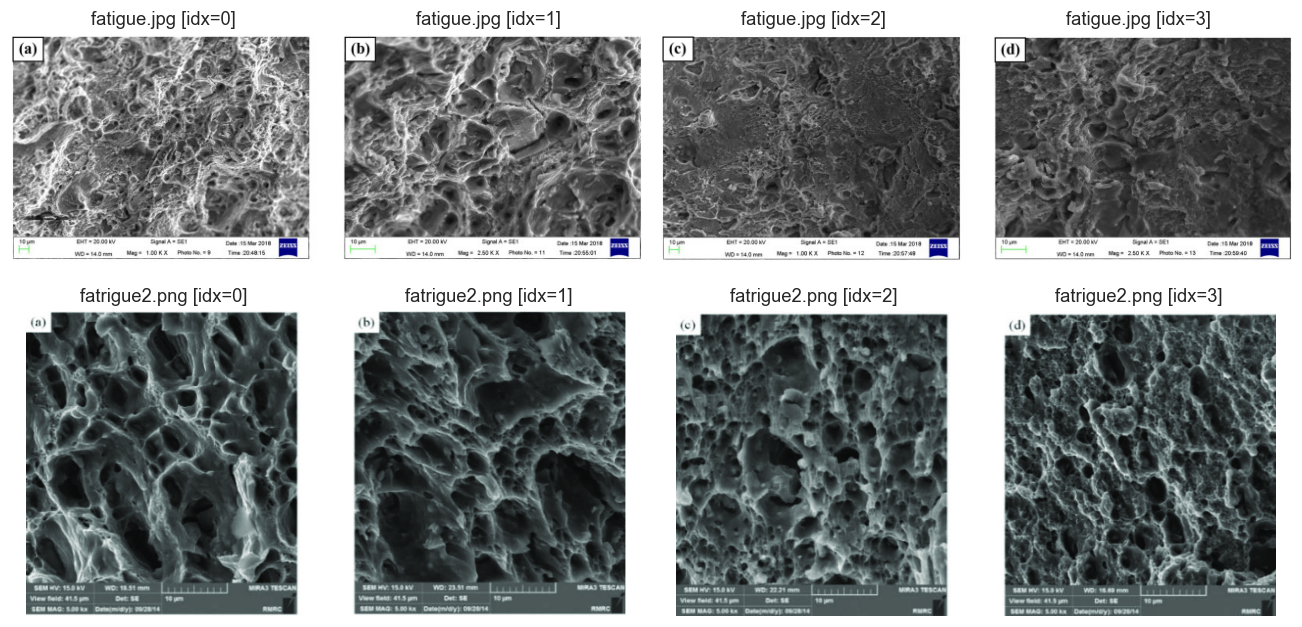

In [5]:
# 9) Vista previa rápida del dataset: miniaturas de 4 especímenes por imagen
if not DF_IMAGES.empty:
    n = len(DF_IMAGES)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(12, 3*n))
    if n == 1:
        axes = np.array([axes])
    for i, (_, row) in enumerate(DF_IMAGES.iterrows()):
        try:
            img_rgb, _ = load_image(Path(row['file']))
            quads = split_quadrants(img_rgb)
            for j in range(4):
                ax = axes[i, j]
                ax.imshow(quads[j])
                ax.set_axis_off()
                ax.set_title(f"{Path(row['file']).name} [idx={j}]")
        except Exception as ex:
            for j in range(4):
                axes[i, j].set_axis_off()
                axes[i, j].set_title(f"Error: {Path(row['file']).name}")
            logger.warning(f"Fallo mostrando {row['file']}: {ex}")
    fig.tight_layout()
    if images_dir:
        p = images_dir / 'p05_overview_thumbnails.png'
        save_fig(p)
    plt.show()

In [6]:
# 10) Análisis avanzado (opcional): esquinas, Hough (líneas/círculos), texturas (GLCM)
from typing import Any

try:
    from skimage.feature import graycomatrix, graycoprops
except Exception:
    graycomatrix = None
    graycoprops = None


def load_main_and_specimen_simple(path: str, idx: int) -> Tuple[np.ndarray, np.ndarray]:
    """Carga una imagen principal y devuelve el espécimen (cuadrante) idx."""
    img_rgb, _ = load_image(Path(path))
    quads = split_quadrants(img_rgb)
    idx = max(0, min(3, int(idx)))
    return img_rgb, quads[idx]


def advanced_analysis(img_rgb: np.ndarray, label: str, save_prefix: str, auto_save: bool = True) -> Dict[str, Any]:
    results: Dict[str, Any] = {}
    # Gris 8-bit
    if cv2 is not None:
        gray8 = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    else:
        g = color.rgb2gray(img_rgb) if 'color' in globals() and hasattr(color,'rgb2gray') else (img_rgb[...,0].astype(np.float32)/255.0)
        gray8 = (np.clip(g,0,1)*255).astype(np.uint8)

    # 10.1 Esquinas (Harris o Shi-Tomasi)
    if cv2 is not None:
        corners = cv2.goodFeaturesToTrack(gray8, maxCorners=200, qualityLevel=0.01, minDistance=7)
        corners = np.intp(corners) if corners is not None else None
        overlay = img_rgb.copy()
        if corners is not None:
            for c in corners:
                x, y = c.ravel()
                cv2.circle(overlay, (int(x), int(y)), 3, (255,0,0), -1)
    else:
        resp = feature.corner_harris(gray8)
        coords = feature.corner_peaks(resp, min_distance=7, threshold_rel=0.02, num_peaks=200)
        overlay = img_rgb.copy()
        for y, x in coords:
            rr, cc = y, x
            overlay[max(rr-2,0):rr+3, max(cc-2,0):cc+3] = [255,0,0]
    plt.figure(figsize=(6,5)); plt.imshow(overlay); plt.axis('off'); plt.title('Detección de esquinas')
    if auto_save:
        p = images_dir / f'{save_prefix}_corners.png'; save_fig(p); results['corners_img'] = p
    plt.show()

    # 10.2 Líneas (Hough probabilístico)
    edges = cv2.Canny(gray8, 50, 150) if cv2 is not None else feature.canny(gray8/255.0, sigma=2.0)
    line_overlay = img_rgb.copy()
    if cv2 is not None:
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=40, maxLineGap=10)
        if lines is not None:
            for l in lines[:,0,:]:
                x1,y1,x2,y2 = l
                cv2.line(line_overlay, (x1,y1), (x2,y2), (0,255,0), 2)
    else:
        from skimage.transform import probabilistic_hough_line
        lines = probabilistic_hough_line(edges, threshold=10, line_length=30, line_gap=5)
        for (p0, p1) in lines:
            rr, cc = p0[1], p0[0]
            rr2, cc2 = p1[1], p1[0]
            plt.plot([p0[0], p1[0]], [p0[1], p1[1]], '-g', linewidth=2)
    plt.figure(figsize=(6,5)); plt.imshow(line_overlay); plt.axis('off'); plt.title('Hough líneas (sobre Canny)')
    if auto_save:
        p = images_dir / f'{save_prefix}_hough_lines.png'; save_fig(p); results['hough_lines_img'] = p
    plt.show()

    # 10.3 Círculos (HoughCircles en OpenCV)
    circ_overlay = img_rgb.copy()
    if cv2 is not None:
        # Suavizar para mejorar estabilidad
        bl = cv2.medianBlur(gray8, 5)
        circles = cv2.HoughCircles(bl, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=100, param2=20, minRadius=5, maxRadius=80)
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for c in circles[0, :]:
                center = (c[0], c[1]); rad = c[2]
                cv2.circle(circ_overlay, center, rad, (255,255,0), 2)
    else:
        # skimage Hough circle (más costoso) omitido por simplicidad
        pass
    plt.figure(figsize=(6,5)); plt.imshow(circ_overlay); plt.axis('off'); plt.title('Hough círculos (poros)')
    if auto_save:
        p = images_dir / f'{save_prefix}_hough_circles.png'; save_fig(p); results['hough_circles_img'] = p
    plt.show()

    # 10.4 Texturas GLCM (contraste, homogeneidad, energía, correlación)
    glcm_metrics = None
    if graycomatrix is not None and graycoprops is not None:
        # Asegurar 8-bit
        g8 = gray8
        distances = [1, 2, 4]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        M = graycomatrix(g8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        props = {
            'contrast': graycoprops(M, 'contrast').mean(),
            'dissimilarity': graycoprops(M, 'dissimilarity').mean(),
            'homogeneity': graycoprops(M, 'homogeneity').mean(),
            'ASM': graycoprops(M, 'ASM').mean(),
            'energy': graycoprops(M, 'energy').mean(),
            'correlation': graycoprops(M, 'correlation').mean(),
        }
        glcm_metrics = props
        results['glcm'] = props
        # Guardar como tabla pequeña
        df = pd.DataFrame([props])
        p = data_dir / f'{save_prefix}_glcm.csv'
        df.to_csv(p, index=False)
        results['glcm_csv'] = p
    else:
        results['glcm'] = None

    return results

[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_corners.png


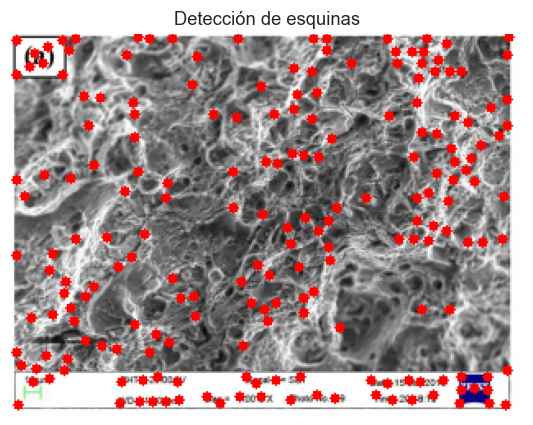

[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_hough_lines.png


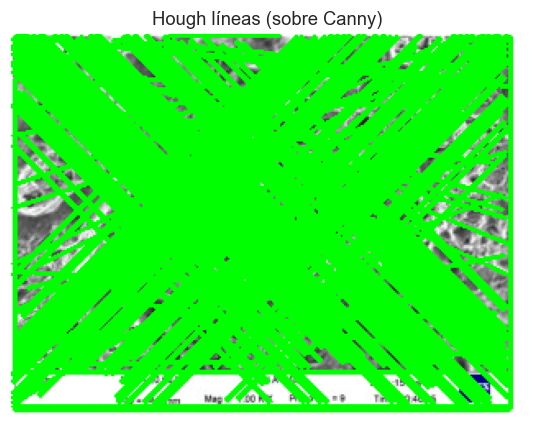

[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_hough_circles.png


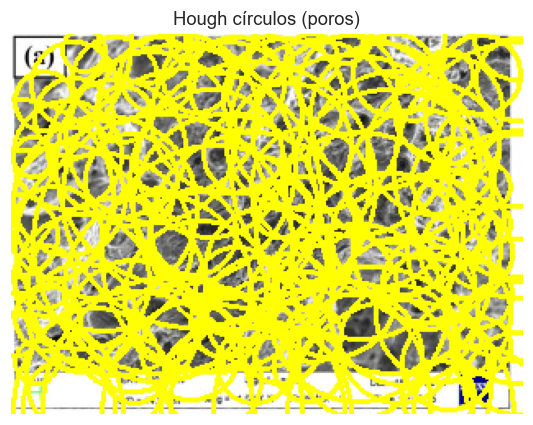

Análisis avanzado completado. Resultados:
- corners_img : c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_corners.png
- hough_lines_img : c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_hough_lines.png
- hough_circles_img : c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_hough_circles.png
- glcm : {'contrast': np.float64(2037.602708921113), 'dissimilarity': np.float64(30.990919787214633), 'homogeneity': np.float64(0.08930707904937778), 'ASM': np.float64(0.0015146948532636522), 'energy': np.float64(0.03868384577876626), 'correlation': np.float64(0.714436964418392)}
- glcm_csv : c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\fatigue_spec0_adv_glcm.csv


In [7]:
# 11) Ejecutar análisis avanzado de ejemplo en un espécimen (no interactivo)
# Usaremos el primer archivo detectado y el espécimen 0
if not DF_IMAGES.empty:
    test_path = DF_IMAGES.iloc[0]['file']
    _, spec0 = load_main_and_specimen_simple(test_path, 0)
    pref = f"{Path(test_path).stem}_spec0_adv"
    adv = advanced_analysis(spec0, label='spec0', save_prefix=pref, auto_save=True)
    print('Análisis avanzado completado. Resultados:')
    for k, v in adv.items():
        print('-', k, ':', v)
else:
    print('Sin imágenes para el ejemplo avanzado.')

In [ ]:
# 12) Procesamiento por lotes (todas las imágenes y 4 especímenes)
from tqdm.auto import tqdm

def batch_process_all(save_adv: bool = True) -> pd.DataFrame:
    rows = []
    for _, r in tqdm(DF_IMAGES.iterrows(), total=len(DF_IMAGES), desc='Procesando imágenes'):
        img_path = r['file']
        try:
            main, _ = load_main_and_specimen_simple(img_path, 0)
            for idx in range(4):
                _, spec = load_main_and_specimen_simple(img_path, idx)
                base = f"{Path(img_path).stem}_spec{idx}"
                _ = analyze_specimen(spec, label=f'spec{idx}', save_prefix=base, auto_save=True)
                if save_adv:
                    adv = advanced_analysis(spec, label=f'spec{idx}', save_prefix=f"{base}_adv", auto_save=True)
                    # Guardar métricas de textura si existen
                    glcm = adv.get('glcm') or {}
                    glcm_row = {'image': Path(img_path).name, 'specimen_idx': idx}
                    glcm_row.update(glcm)
                    rows.append(glcm_row)
        except Exception as ex:
            logger.warning(f'Fallo en {img_path}: {ex}')
    df = pd.DataFrame(rows)
    if not df.empty:
        out_csv = data_dir / 'p05_batch_glcm.csv'
        df.to_csv(out_csv, index=False)
        print('Métricas GLCM guardadas en:', out_csv)
    return df

# Para ejecutar manualmente desde el notebook, descomenta:
# df_metrics = batch_process_all(save_adv=True)


In [9]:
# 13) Actualizar p5.md con una sección de resultados automáticos (opcional)
import textwrap

try:
    repo_root_path = Path.cwd().parent.parent.parent
    p5_md_path = repo_root_path / 'Practicas' / 'P05_Analisis_Imagen' / 'p5.md'
    if not p5_md_path.exists():
        print('Advertencia: No se encontró p5.md en Practicas/P05_Analisis_Imagen; se omitirá actualización.')
    else:
        md_parent = p5_md_path.parent
        img_rel = os.path.relpath(images_dir.resolve(), md_parent.resolve()).replace(os.path.sep, '/')
        content = p5_md_path.read_text(encoding='utf-8')
        marker_start = '<!-- P05_AUTO_RESULTS_START -->'
        marker_end = '<!-- P05_AUTO_RESULTS_END -->'
        section = f"""
{marker_start}
## Resultados Automáticos (P05)
*(Actualizado: {dt.datetime.now().isoformat()})*

Vista general del dataset:

![Thumbnails]({img_rel}/p05_overview_thumbnails.png)

Ejemplos de análisis por espécimen (puedes regenerarlos con los widgets y el procesamiento por lotes):

- Ecualización/CLAHE: `{img_rel}/fatigue_spec0_equalization.png`
- Bordes: `{img_rel}/fatigue_spec0_edges.png`
- Morfología: `{img_rel}/fatigue_spec0_morph.png`
- Esquinas: `{img_rel}/fatigue_spec0_adv_corners.png`
- Hough líneas: `{img_rel}/fatigue_spec0_adv_hough_lines.png`
- Hough círculos: `{img_rel}/fatigue_spec0_adv_hough_circles.png`

Para métricas de texturas, consulta `data/p05_batch_glcm.csv` cuando ejecutes el procesamiento por lotes.
{marker_end}
"""
        # Insertar o reemplazar sección
        import re as _re
        pattern = _re.compile(_re.escape(marker_start) + r"[\s\S]*?" + _re.escape(marker_end), _re.MULTILINE)
        if pattern.search(content):
            content2 = pattern.sub(section, content)
        else:
            content2 = content + '\n\n' + section
        p5_md_path.write_text(content2, encoding='utf-8')
        print('Sección de resultados auto-insertada/actualizada en p5.md')
except Exception as ex:
    print('No se pudo actualizar p5.md:', ex)


Sección de resultados auto-insertada/actualizada en p5.md


In [ ]:
# 14) Widgets avanzados para análisis (tunable) con recorte de banner (ROI)
if widgets is None:
    print('Widgets no disponibles para el análisis avanzado tunable.')
else:
    # Parámetros
    s_maxCorners = widgets.IntSlider(value=150, min=20, max=500, step=10, description='maxCorners')
    s_quality = widgets.FloatSlider(value=0.03, min=0.001, max=0.2, step=0.005, readout_format='.3f', description='quality')
    s_minDist = widgets.IntSlider(value=9, min=1, max=50, step=1, description='minDist')

    s_canny1 = widgets.IntSlider(value=80, min=0, max=255, step=5, description='Canny T1')
    s_canny2 = widgets.IntSlider(value=180, min=0, max=255, step=5, description='Canny T2')

    s_hough_thr = widgets.IntSlider(value=120, min=10, max=300, step=5, description='Hough thr')
    s_line_len = widgets.IntSlider(value=60, min=10, max=300, step=5, description='Line len')
    s_line_gap = widgets.IntSlider(value=10, min=1, max=50, step=1, description='Line gap')

    s_dp = widgets.FloatSlider(value=1.2, min=0.8, max=2.0, step=0.05, readout_format='.2f', description='Circles dp')
    s_minDistCir = widgets.IntSlider(value=25, min=5, max=150, step=5, description='Circ minDist')
    s_p1 = widgets.IntSlider(value=100, min=10, max=300, step=5, description='Circ p1')
    s_p2 = widgets.IntSlider(value=30, min=5, max=150, step=1, description='Circ p2')
    s_rmin = widgets.IntSlider(value=8, min=0, max=100, step=1, description='R min')
    s_rmax = widgets.IntSlider(value=50, min=10, max=250, step=5, description='R max')
    s_crop = widgets.IntSlider(value=70, min=0, max=200, step=5, description='Crop bottom px')
    s_max_draw = widgets.IntSlider(value=150, min=10, max=500, step=10, description='Max draw')

    out_adv = widgets.Output()

    def advanced_analysis_tuned(img_rgb: np.ndarray, save_prefix: str):
        # Recorte inferior para evitar texto/escala
        if s_crop.value > 0:
            h = img_rgb.shape[0]
            img_proc = img_rgb[:max(h - s_crop.value, 1), :, :]
        else:
            img_proc = img_rgb
        # Gris
        gray8 = cv2.cvtColor(img_proc, cv2.COLOR_RGB2GRAY) if cv2 is not None else (color.rgb2gray(img_proc)*255).astype(np.uint8)

        # Esquinas
        overlay = img_proc.copy()
        if cv2 is not None:
            corners = cv2.goodFeaturesToTrack(gray8, maxCorners=s_maxCorners.value, qualityLevel=float(s_quality.value), minDistance=int(s_minDist.value))
            if corners is not None:
                corners = np.intp(corners)[:s_max_draw.value]
                for c in corners:
                    x, y = c.ravel()
                    cv2.circle(overlay, (int(x), int(y)), 3, (255,0,0), -1)
        else:
            resp = feature.corner_harris(gray8)
            coords = feature.corner_peaks(resp, min_distance=int(s_minDist.value), threshold_rel=float(s_quality.value), num_peaks=int(s_max_draw.value))
            for y, x in coords:
                overlay[max(y-2,0):y+3, max(x-2,0):x+3] = [255,0,0]
        plt.figure(figsize=(6,5)); plt.imshow(overlay); plt.axis('off'); plt.title('Esquinas (tuned)')
        p = images_dir / f'{save_prefix}_tuned_corners.png'; save_fig(p)
        plt.show()

        # Canny
        if cv2 is not None:
            edges = cv2.Canny(gray8, int(s_canny1.value), int(s_canny2.value))
        else:
            edges = feature.canny(gray8/255.0, sigma=2.0)
        # Hough líneas
        line_overlay = img_proc.copy()
        if cv2 is not None:
            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=int(s_hough_thr.value), minLineLength=int(s_line_len.value), maxLineGap=int(s_line_gap.value))
            if lines is not None:
                lines = lines[:s_max_draw.value]
                for l in lines[:,0,:]:
                    x1,y1,x2,y2 = l
                    cv2.line(line_overlay, (x1,y1), (x2,y2), (0,255,0), 2)
        else:
            from skimage.transform import probabilistic_hough_line
            lines = probabilistic_hough_line(edges, threshold=int(s_hough_thr.value), line_length=int(s_line_len.value), line_gap=int(s_line_gap.value))
            lines = lines[:s_max_draw.value]
            for (p0,p1) in lines:
                plt.plot([p0[0], p1[0]], [p0[1], p1[1]], '-g', linewidth=2)
        plt.figure(figsize=(6,5)); plt.imshow(line_overlay); plt.axis('off'); plt.title('Hough líneas (tuned)')
        p = images_dir / f'{save_prefix}_tuned_hough_lines.png'; save_fig(p)
        plt.show()

        # Hough círculos (OpenCV)
        circ_overlay = img_proc.copy()
        if cv2 is not None:
            bl = cv2.medianBlur(gray8, 5)
            circles = cv2.HoughCircles(bl, cv2.HOUGH_GRADIENT, dp=float(s_dp.value), minDist=int(s_minDistCir.value), param1=int(s_p1.value), param2=int(s_p2.value), minRadius=int(s_rmin.value), maxRadius=int(s_rmax.value))
            if circles is not None:
                circles = np.uint16(np.around(circles))
                circles = circles[:, :min(circles.shape[1], int(s_max_draw.value)), :]
                for c in circles[0, :]:
                    center = (int(c[0]), int(c[1])); rad = int(c[2])
                    cv2.circle(circ_overlay, center, rad, (255,255,0), 2)
        plt.figure(figsize=(6,5)); plt.imshow(circ_overlay); plt.axis('off'); plt.title('Hough círculos (tuned)')
        p = images_dir / f'{save_prefix}_tuned_hough_circles.png'; save_fig(p)
        plt.show()

    def run_tuned(_=None):
        with out_adv:
            out_adv.clear_output(wait=True)
            try:
                _, spec = load_main_and_specimen_simple(dd_images.value, spec_idx.value)
                pref = f"{Path(dd_images.value).stem}_spec{spec_idx.value}_adv"
                advanced_analysis_tuned(spec, pref)
                print('Análisis avanzado (tuned) terminado y guardado.')
            except Exception as ex:
                print('Error en análisis tuned:', ex)

    btn_run = widgets.Button(description='Ejecutar tuned', button_style='primary')
    btn_run.on_click(run_tuned)

    ui_adv = widgets.VBox([
        widgets.HBox([s_maxCorners, s_quality, s_minDist]),
        widgets.HBox([s_canny1, s_canny2]),
        widgets.HBox([s_hough_thr, s_line_len, s_line_gap]),
        widgets.HBox([s_dp, s_minDistCir, s_p1, s_p2]),
        widgets.HBox([s_rmin, s_rmax, s_crop, s_max_draw]),
        btn_run, out_adv
    ])
    display(ui_adv)

[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_tuned_corners_quick.png


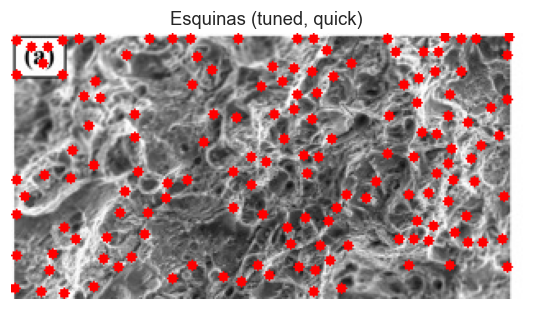

[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_tuned_hough_lines_quick.png


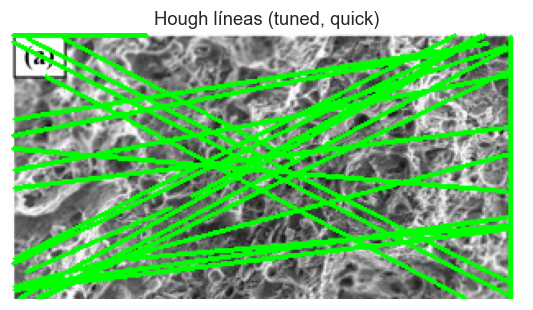

[INFO] Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P05_Analisis_Imagen\data\images\fatigue_spec0_adv_tuned_hough_circles_quick.png


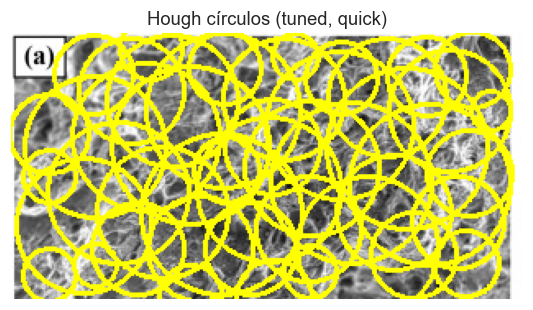

In [8]:
# 15) Ejecución rápida del tuned con valores por defecto (no interactivo)
if not DF_IMAGES.empty:
    test_path = DF_IMAGES.iloc[0]['file']
    _, spec0 = load_main_and_specimen_simple(test_path, 0)
    # Simular la función tuned con parámetros por defecto sin widgets
    # Copiamos la lógica principal con los defaults del slider
    crop = 70
    img_proc = spec0[:max(spec0.shape[0]-crop,1), :, :]
    gray8 = cv2.cvtColor(img_proc, cv2.COLOR_RGB2GRAY) if cv2 is not None else (color.rgb2gray(img_proc)*255).astype(np.uint8)

    # Esquinas
    overlay = img_proc.copy()
    if cv2 is not None:
        corners = cv2.goodFeaturesToTrack(gray8, maxCorners=150, qualityLevel=0.03, minDistance=9)
        if corners is not None:
            corners = np.intp(corners)[:150]
            for c in corners:
                x, y = c.ravel()
                cv2.circle(overlay, (int(x), int(y)), 3, (255,0,0), -1)
    plt.figure(figsize=(6,5)); plt.imshow(overlay); plt.axis('off'); plt.title('Esquinas (tuned, quick)')
    p = images_dir / f'{Path(test_path).stem}_spec0_adv_tuned_corners_quick.png'; save_fig(p); plt.show()

    # Canny + Hough líneas
    edges = cv2.Canny(gray8, 80, 180) if cv2 is not None else feature.canny(gray8/255.0, sigma=2.0)
    line_overlay = img_proc.copy()
    if cv2 is not None:
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=120, minLineLength=60, maxLineGap=10)
        if lines is not None:
            lines = lines[:150]
            for l in lines[:,0,:]:
                x1,y1,x2,y2 = l
                cv2.line(line_overlay, (x1,y1), (x2,y2), (0,255,0), 2)
    plt.figure(figsize=(6,5)); plt.imshow(line_overlay); plt.axis('off'); plt.title('Hough líneas (tuned, quick)')
    p = images_dir / f'{Path(test_path).stem}_spec0_adv_tuned_hough_lines_quick.png'; save_fig(p); plt.show()

    # Hough círculos
    circ_overlay = img_proc.copy()
    if cv2 is not None:
        bl = cv2.medianBlur(gray8, 5)
        circles = cv2.HoughCircles(bl, cv2.HOUGH_GRADIENT, dp=1.2, minDist=25, param1=100, param2=30, minRadius=8, maxRadius=50)
        if circles is not None:
            circles = np.uint16(np.around(circles))
            circles = circles[:, :min(circles.shape[1], 150), :]
            for c in circles[0, :]:
                center = (int(c[0]), int(c[1])); rad = int(c[2])
                cv2.circle(circ_overlay, center, rad, (255,255,0), 2)
    plt.figure(figsize=(6,5)); plt.imshow(circ_overlay); plt.axis('off'); plt.title('Hough círculos (tuned, quick)')
    p = images_dir / f'{Path(test_path).stem}_spec0_adv_tuned_hough_circles_quick.png'; save_fig(p); plt.show()
else:
    print('Sin imágenes para el tuned quick run.')